### Finetune the CLIP model on Flickr30K, CoCo dataset

In [1]:
import torch
import torch.nn as nn
from transformers import (
    CLIPProcessor, 
    CLIPModel,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments,
)

from datasets import load_dataset
from zeroshot_retrieval import zeroshot_evaluate
from tqdm import tqdm
from icecream import ic

In [2]:
pretrained_model_path = "openai/clip-vit-base-patch16"
save_path = "saved_clip_model\\clip-vit-base-p16-finetuned_proj_512x512"


In [3]:
dataset = load_dataset(
    'nlphuji/flickr30k',
    cache_dir='cache',
    keep_in_memory=True,
)['test'] # type: ignore

train_dataset = dataset.filter(lambda x: x["split"] == "train")
test_dataset = dataset.filter(lambda x: x["split"] == "test")
val_dataset = dataset.filter(lambda x: x["split"] == "val")

KeyboardInterrupt: 

In [3]:
# torch.save(train_dataset, "data/flickr30k/train_dataset.pt")
# torch.save(test_dataset, "data/flickr30k/test_dataset.pt")
# torch.save(val_dataset, "data/flickr30k/val_dataset.pt")

train_dataset = torch.load("data/flickr30k/train_dataset.pt")
val_dataset = torch.load("data/flickr30k/val_dataset.pt")
test_dataset = torch.load("data/flickr30k/test_dataset.pt")

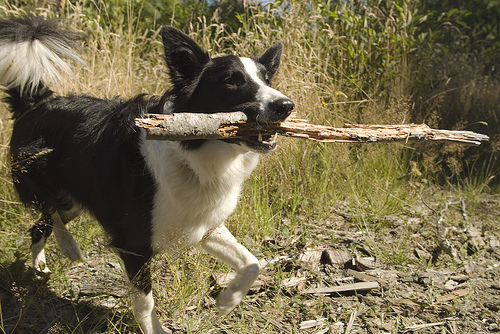

In [17]:
train_dataset[719]['image']

In [3]:
model = CLIPModel.from_pretrained(pretrained_model_path, cache_dir="cache").cuda()
# model.visual_projection = nn.Linear(in_features=768, out_features=768, bias=False)
# model.text_projection = nn.Linear(in_features=512, out_features=768, bias=False)

processor = CLIPProcessor.from_pretrained(pretrained_model_path, cache_dir="cache")

In [6]:
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05, element

In [5]:
# tmp = []
def tokenize_function(examples, max_seq_length=77):
    # 先获取句子, 这里一个图片对应五个句子，我们将其拼成一个句子
    # tmp.append(examples)
    text = [" ".join('%s' %a for a in sentence) for sentence in examples['caption']]
    
    # MCSE里只随机抽取一个标题来创建图片句子对

    image = [image.convert("RGB") for image in examples['image']]
    processed_data = processor(
        images=image, 
        text=text,
        padding='max_length',
        max_length=max_seq_length,
        truncation=True,
        return_attention_mask=True, 
        return_tensors='pt',
    )
    batch = {
        'input_ids':processed_data['input_ids'],
        # 'token_type_ids':processed_data['token_type_ids'],
        'attention_mask':processed_data['attention_mask'],
        'pixel_values':processed_data['pixel_values'],
    }

    return batch

In [6]:
# tokenlizing
tokenized_train_dataset = train_dataset.map(
        tokenize_function, 
        batched=True, 
        remove_columns=['image', 'split','caption','sentids', 'img_id', 'filename'], 
        # keep_in_memory = True,
        batch_size = 500,
    )
torch.save(tokenized_train_dataset, "tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/tokenized_train_batched_500.pt")

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

RuntimeError: Parent directory tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16 does not exist.

In [8]:
tokenized_eval_dataset = val_dataset.map(
        tokenize_function, 
        batched=True, 
        remove_columns=['image', 'split','caption','sentids', 'img_id', 'filename'],
        # keep_in_memory = True,
        batch_size = 500,
    )

torch.save(tokenized_eval_dataset, "tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/tokenized_eval_batched_500.pt")

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

In [9]:
tokenized_test_dataset = test_dataset.map(
        tokenize_function, 
        batched=True, 
        remove_columns=['image', 'split','caption','sentids', 'img_id', 'filename'],
        # keep_in_memory = True,
        batch_size = 500,
    )
torch.save(tokenized_test_dataset, "tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/tokenized_test_batched_500.pt")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [5]:
tokenized_train_dataset = torch.load("tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/tokenized_train_batched_500.pt")
tokenized_eval_dataset = torch.load("tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/tokenized_eval_batched_500.pt")
tokenized_test_dataset = torch.load("tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/tokenized_test_batched_500.pt")

In [11]:
tokenized_train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'pixel_values'],
    num_rows: 29000
})

In [ ]:
# # tmp = []
# # tmp1 = []
# def collate_fn_epoch(examples):  # evaluation_strategy = "epoch"
#     pixel_values = torch.stack([torch.tensor(example["pixel_values"]) for example in examples], dim=0)
#     input_ids = torch.tensor([example["input_ids"] for example in examples], dtype=torch.long)
#     attention_mask = torch.tensor([example["attention_mask"] for example in examples], dtype=torch.long)
#     return {
#         "pixel_values": pixel_values,
#         "input_ids": input_ids,
#         "attention_mask": attention_mask,
#         "return_loss": True,
#     }

In [6]:
def collate_fn_steps(examples):  # evaluation_strategy = "steps"
    pixel_values = torch.stack([torch.tensor(example["pixel_values"]) for example in examples], dim=0).squeeze(0)
    input_ids = torch.tensor([example["input_ids"] for example in examples], dtype=torch.long).squeeze(1)
    attention_mask = torch.tensor([example["attention_mask"] for example in examples], dtype=torch.long).squeeze(1)
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }

In [ ]:
# #FREEZE
# for i,j in model.named_parameters():
#     if 'prompt' not in i:
#         j.requires_grad=False

In [7]:
earlystop = EarlyStoppingCallback(early_stopping_patience=10)

training_args = TrainingArguments(
    output_dir            = save_path,
    evaluation_strategy   = "steps",
    learning_rate         = 3e-6,
    weight_decay          = 1e-6,
    save_steps            = 50,
    eval_steps            = 50,
    num_train_epochs      = 20,
    save_strategy         = "steps",
    remove_unused_columns = False,
    warmup_steps          = 50,
    per_device_train_batch_size = 128,
    per_device_eval_batch_size  = 128,
    lr_scheduler_type     = "cosine",
    label_smoothing_factor= 0.05,
    # auto_find_batch_size  = True,
    metric_for_best_model = "eval_loss",  # for earlystop
    # metric_for_best_model = "eval_acc",  # for earlystop
    load_best_model_at_end = True,
    save_total_limit = 1,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    # compute_metrics=compute_metrics,
    data_collator=collate_fn_steps,
    callbacks=[earlystop],
)

train_result = trainer.train()
results = zeroshot_evaluate(model=model,dataloader=test_dataset,processor=processor,max_seq_length=77,recall_k_list=[1,5,10],device=torch.device("cuda")) # type: ignore

ic(results)

d:\Conda_data\envs\py39\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/4540 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04100579395890236, 'eval_runtime': 86.5031, 'eval_samples_per_second': 11.722, 'eval_steps_per_second': 0.092, 'epoch': 0.22}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.037126973271369934, 'eval_runtime': 290.489, 'eval_samples_per_second': 3.491, 'eval_steps_per_second': 0.028, 'epoch': 0.44}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.03197653591632843, 'eval_runtime': 260.7709, 'eval_samples_per_second': 3.888, 'eval_steps_per_second': 0.031, 'epoch': 0.66}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.03223315253853798, 'eval_runtime': 179.2813, 'eval_samples_per_second': 5.656, 'eval_steps_per_second': 0.045, 'epoch': 0.88}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.030666735023260117, 'eval_runtime': 213.0222, 'eval_samples_per_second': 4.76, 'eval_steps_per_second': 0.038, 'epoch': 1.1}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.027695270255208015, 'eval_runtime': 369.4027, 'eval_samples_per_second': 2.745, 'eval_steps_per_second': 0.022, 'epoch': 1.32}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.03091454692184925, 'eval_runtime': 160.9033, 'eval_samples_per_second': 6.302, 'eval_steps_per_second': 0.05, 'epoch': 1.54}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.024753112345933914, 'eval_runtime': 161.3522, 'eval_samples_per_second': 6.284, 'eval_steps_per_second': 0.05, 'epoch': 1.76}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.027117950841784477, 'eval_runtime': 123.4832, 'eval_samples_per_second': 8.212, 'eval_steps_per_second': 0.065, 'epoch': 1.98}
{'loss': 0.0228, 'learning_rate': 2.9262601027122918e-06, 'epoch': 2.2}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.025342335924506187, 'eval_runtime': 126.4484, 'eval_samples_per_second': 8.019, 'eval_steps_per_second': 0.063, 'epoch': 2.2}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.02631325274705887, 'eval_runtime': 162.0537, 'eval_samples_per_second': 6.257, 'eval_steps_per_second': 0.049, 'epoch': 2.42}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.02228839136660099, 'eval_runtime': 142.5704, 'eval_samples_per_second': 7.112, 'eval_steps_per_second': 0.056, 'epoch': 2.64}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.023452242836356163, 'eval_runtime': 123.1398, 'eval_samples_per_second': 8.235, 'eval_steps_per_second': 0.065, 'epoch': 2.86}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.02112811617553234, 'eval_runtime': 124.4062, 'eval_samples_per_second': 8.151, 'eval_steps_per_second': 0.064, 'epoch': 3.08}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.02753043919801712, 'eval_runtime': 183.6866, 'eval_samples_per_second': 5.52, 'eval_steps_per_second': 0.044, 'epoch': 3.3}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.020490970462560654, 'eval_runtime': 204.186, 'eval_samples_per_second': 4.966, 'eval_steps_per_second': 0.039, 'epoch': 3.52}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.017199190333485603, 'eval_runtime': 201.3787, 'eval_samples_per_second': 5.035, 'eval_steps_per_second': 0.04, 'epoch': 3.74}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.018866846337914467, 'eval_runtime': 134.4455, 'eval_samples_per_second': 7.542, 'eval_steps_per_second': 0.06, 'epoch': 3.96}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.017989730462431908, 'eval_runtime': 136.9788, 'eval_samples_per_second': 7.403, 'eval_steps_per_second': 0.058, 'epoch': 4.19}
{'loss': 0.0091, 'learning_rate': 2.6806507362134866e-06, 'epoch': 4.41}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.015972988680005074, 'eval_runtime': 215.6794, 'eval_samples_per_second': 4.701, 'eval_steps_per_second': 0.037, 'epoch': 4.41}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.02190450020134449, 'eval_runtime': 280.9598, 'eval_samples_per_second': 3.609, 'eval_steps_per_second': 0.028, 'epoch': 4.63}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.02146543189883232, 'eval_runtime': 278.747, 'eval_samples_per_second': 3.638, 'eval_steps_per_second': 0.029, 'epoch': 4.85}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.020449809730052948, 'eval_runtime': 147.5741, 'eval_samples_per_second': 6.871, 'eval_steps_per_second': 0.054, 'epoch': 5.07}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.019051184877753258, 'eval_runtime': 260.5636, 'eval_samples_per_second': 3.892, 'eval_steps_per_second': 0.031, 'epoch': 5.29}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.02070806175470352, 'eval_runtime': 346.5099, 'eval_samples_per_second': 2.926, 'eval_steps_per_second': 0.023, 'epoch': 5.51}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.01641174405813217, 'eval_runtime': 349.4167, 'eval_samples_per_second': 2.902, 'eval_steps_per_second': 0.023, 'epoch': 5.73}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.017559384927153587, 'eval_runtime': 341.8638, 'eval_samples_per_second': 2.966, 'eval_steps_per_second': 0.023, 'epoch': 5.95}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.015695979818701744, 'eval_runtime': 106.1309, 'eval_samples_per_second': 9.554, 'eval_steps_per_second': 0.075, 'epoch': 6.17}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.018226299434900284, 'eval_runtime': 106.0691, 'eval_samples_per_second': 9.56, 'eval_steps_per_second': 0.075, 'epoch': 6.39}
{'loss': 0.0067, 'learning_rate': 2.2920089339728766e-06, 'epoch': 6.61}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.01620025373995304, 'eval_runtime': 106.2752, 'eval_samples_per_second': 9.541, 'eval_steps_per_second': 0.075, 'epoch': 6.61}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.014558885246515274, 'eval_runtime': 106.2569, 'eval_samples_per_second': 9.543, 'eval_steps_per_second': 0.075, 'epoch': 6.83}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.016869178041815758, 'eval_runtime': 105.9959, 'eval_samples_per_second': 9.566, 'eval_steps_per_second': 0.075, 'epoch': 7.05}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.013549432158470154, 'eval_runtime': 106.1385, 'eval_samples_per_second': 9.554, 'eval_steps_per_second': 0.075, 'epoch': 7.27}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.012725824490189552, 'eval_runtime': 106.2114, 'eval_samples_per_second': 9.547, 'eval_steps_per_second': 0.075, 'epoch': 7.49}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.014284835197031498, 'eval_runtime': 106.1034, 'eval_samples_per_second': 9.557, 'eval_steps_per_second': 0.075, 'epoch': 7.71}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.016928531229496002, 'eval_runtime': 106.2816, 'eval_samples_per_second': 9.541, 'eval_steps_per_second': 0.075, 'epoch': 7.93}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.014731899835169315, 'eval_runtime': 106.0987, 'eval_samples_per_second': 9.557, 'eval_steps_per_second': 0.075, 'epoch': 8.15}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.014915818348526955, 'eval_runtime': 106.2202, 'eval_samples_per_second': 9.546, 'eval_steps_per_second': 0.075, 'epoch': 8.37}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.013295972719788551, 'eval_runtime': 105.3935, 'eval_samples_per_second': 9.621, 'eval_steps_per_second': 0.076, 'epoch': 8.59}
{'loss': 0.0052, 'learning_rate': 1.8074175308208877e-06, 'epoch': 8.81}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.01578662358224392, 'eval_runtime': 105.4857, 'eval_samples_per_second': 9.613, 'eval_steps_per_second': 0.076, 'epoch': 8.81}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.017592521384358406, 'eval_runtime': 105.2801, 'eval_samples_per_second': 9.631, 'eval_steps_per_second': 0.076, 'epoch': 9.03}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.014997384510934353, 'eval_runtime': 105.2152, 'eval_samples_per_second': 9.637, 'eval_steps_per_second': 0.076, 'epoch': 9.25}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.01462580170482397, 'eval_runtime': 105.4917, 'eval_samples_per_second': 9.612, 'eval_steps_per_second': 0.076, 'epoch': 9.47}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.015933632850646973, 'eval_runtime': 123.7055, 'eval_samples_per_second': 8.197, 'eval_steps_per_second': 0.065, 'epoch': 9.69}
{'train_runtime': 85471.1685, 'train_samples_per_second': 6.786, 'train_steps_per_second': 0.053, 'train_loss': 0.010337589843706651, 'epoch': 9.69}


NameError: name 'test_dataset' is not defined

In [8]:
trainer.save_model()

In [9]:
# For KeyboardInterrupt usage
test_dataset = torch.load("data/flickr30k/test_dataset.pt")
zeroshot_evaluate(model=model,dataloader=test_dataset,processor=processor,max_seq_length=77,recall_k_list=[1,5,10],device=torch.device("cuda")) 

0it [00:00, ?it/s]

1000it [01:03, 15.68it/s]


{'image_retrieval_recall@1': 0.7523999810218811,
 'text_retrieval_recall@1': 0.8970000147819519,
 'image_retrieval_recall@5': 0.9343999624252319,
 'text_retrieval_recall@5': 0.9880000352859497,
 'image_retrieval_recall@10': 0.9666000008583069,
 'text_retrieval_recall@10': 0.9930000305175781}

### Zero-shot Cross-Modal Retrieval on Flickr30k

In [3]:
from zeroshot_retrieval import zeroshot_evaluate
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from transformers import (
    CLIPProcessor, 
    CLIPModel,
    CLIPConfig,
)

test_dataset = torch.load("data/flickr30k/test_dataset.pt")
pretrained_model_path = "openai/clip-vit-base-patch32"
save_path = "saved_clip_model\\clip-vit-base-p32-finetuned_proj_768x768"

config = CLIPConfig().from_pretrained(save_path)

# if 512x512
# model = CLIPModel(config).from_pretrained(save_path, cache_dir="cache").cuda()

# if 768x768
model = CLIPModel(config).cuda()
model.visual_projection = torch.nn.Linear(in_features=768, out_features=768, bias=False).cuda()
model.text_projection = torch.nn.Linear(in_features=512, out_features=768, bias=False).cuda()
pretrained_dict = torch.load(save_path+'\\pytorch_model.bin', map_location=device)
model.load_state_dict(pretrained_dict)

processor = CLIPProcessor.from_pretrained(pretrained_model_path, cache_dir="cache")


results = zeroshot_evaluate(model=model,dataloader=test_dataset,processor=processor,max_seq_length=77,recall_k_list=[1,5,10],device=torch.device("cuda")) # type: ignore
print(results)

1000it [00:30, 32.88it/s]


{'image_retrieval_recall@1': 0.47259998321533203, 'text_retrieval_recall@1': 0.6040000319480896, 'image_retrieval_recall@5': 0.764799952507019, 'text_retrieval_recall@5': 0.8880000710487366, 'image_retrieval_recall@10': 0.8491999506950378, 'text_retrieval_recall@10': 0.9360000491142273}


|model|dataset|text-->img|text-->img|text-->img|img-->text|img-->text|img-->text|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| | |R@1|R@5|R@10|R@1|R@5|R@10|
|CLIP|flicker|0.687|0.906|0.952|0.880|0.987|0.994|
|MCSE-BERT|flicker|0.204|0.502|---|0.238|0.525|---|
|CLIP-ViT-base-patch32_proj_512x512|flicker|0.687|0.904|0.948|0.835|0.963|0.987|
|CLIP-ViT-base-patch32_proj_768x768|flicker|0.473|0.764|0.849|0.604|0.888|0.936|
|CLIP-ViT-base-patch16_proj_512x512|flicker|0.752|0.934|0.966|0.897|0.988|0.993|
|CLIP-ViT-base-patch16_proj_768x768|flicker|0.481|0.790|0.871|0.635|0.897|0.949|
|CLIP-ViT-large-patch14_proj_1024x1024|flicker|0.486|0.805|0.887|0.613|0.886|0.947|
|CLIP|COCO2017|0.305|0.547|0.662|0.500|0.748|0.831|
|CLIP-ViT-base-patch32_proj_512x512|COCO2017|0.416|0.683|0.786|0.589|0.827|0.893|
|CLIP-ViT-base-patch32_proj_768x768|COCO2017|0.284|0.575|0.696|0.411|0.712|0.827|

# CLIP original coco
{'image_retrieval_recall@1': 0.3045494258403778,
 'text_retrieval_recall@1': 0.5001999735832214,
 'image_retrieval_recall@5': 0.5478531718254089,
 'text_retrieval_recall@5': 0.7477999925613403,
 'image_retrieval_recall@10': 0.6624290347099304,
 'text_retrieval_recall@10': 0.8317999839782715}

# CLIP-ViT-base-patch32_proj_512x512 coco
{'image_retrieval_recall@1': 0.4162868559360504,
 'text_retrieval_recall@1': 0.5889999866485596,
 'image_retrieval_recall@5': 0.6828175783157349,
 'text_retrieval_recall@5': 0.8273999691009521,
 'image_retrieval_recall@10': 0.7855600714683533,
 'text_retrieval_recall@10': 0.8931999802589417}

# CLIP-ViT-base-patch32_proj_768x768 coco
 {'image_retrieval_recall@1': 0.2845206558704376,
 'text_retrieval_recall@1': 0.4107999801635742,
 'image_retrieval_recall@5': 0.575037956237793,
 'text_retrieval_recall@5': 0.7117999792098999,
 'image_retrieval_recall@10': 0.6962100863456726,
 'text_retrieval_recall@10': 0.8265999555587769}

# clip-vit-large-p14-finetuned_proj_1024x1024 flickr
 {'image_retrieval_recall@1': 0.48559999465942383,
 'text_retrieval_recall@1': 0.6130000352859497,
 'image_retrieval_recall@5': 0.8051999807357788,
 'text_retrieval_recall@5': 0.8860000371932983,
 'image_retrieval_recall@10': 0.8865999579429626,
 'text_retrieval_recall@10': 0.9470000267028809}

### Build Feature Pool

In [1]:
import torch
from transformers import (
    CLIPProcessor, 
    CLIPModel,
    AutoConfig,
)

from datasets import load_dataset

# pretrained_model_path = "openai/clip-vit-base-patch32"
# save_path = "output\\clip-finetuned_proj_768x768"
pretrained_model_path = "openai/clip-vit-base-patch16"
save_path = "saved_clip_model\\clip-vit-base-p16-finetuned_proj_512x512"

# dataset = load_dataset('nlphuji/flickr30k',cache_dir='cache',keep_in_memory=False,)['test'] 
# train_dataset = dataset.filter(lambda x: x["split"] == "train")
train_dataset = torch.load("data/flickr30k/train_dataset.pt")

processor = CLIPProcessor.from_pretrained(pretrained_model_path, cache_dir="cache")

config = AutoConfig.from_pretrained(save_path)
model = CLIPModel(config).from_pretrained(save_path, cache_dir="cache").cuda()

# model = CLIPModel(config).cuda()
# model.visual_projection = torch.nn.Linear(in_features=768, out_features=768, bias=False)
# model.text_projection = torch.nn.Linear(in_features=512, out_features=768, bias=False)
# pretrained_dict = torch.load(save_path+"/pytorch_model.bin")
# model_dict = model.state_dict()
# model_dict.update(pretrained_dict)
# model.load_state_dict(model_dict)


def tokenize_func(examples, max_seq_length=77):
    # 先获取句子, 这里一个图片对应五个句子，我们将其拼成一个句子
    # tmp.append(examples)
    text = [" ".join('%s' %a for a in sentence) for sentence in examples['caption']]
    
    # MCSE里只随机抽取一个标题来创建图片句子对

    image = [image.convert("RGB") for image in examples['image']]
    processed_data = processor(
        images=image, 
        text=text,
        padding='max_length',
        max_length=max_seq_length,
        truncation=True,
        return_attention_mask=True, 
        return_tensors='pt',
    )
    return processed_data


In [2]:
# tokenlizing
tokenized_train_dataset = train_dataset.map(
        tokenize_func, 
        batched=True, 
        remove_columns=['image', 'split','caption','sentids', 'img_id', 'filename'], 
        # keep_in_memory = True,
        batch_size = 500,
    )

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

In [3]:
torch.save(tokenized_train_dataset, "tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/tokenized_train_dataset.pt")

In [4]:
# tokenized_train_dataset = torch.load("tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/tokenized_train_dataset.pt")
pixel_values = torch.stack([torch.tensor(example["pixel_values"]) for example in tokenized_train_dataset], dim=0).squeeze(0)

In [5]:
input_ids = torch.tensor([example["input_ids"] for example in tokenized_train_dataset], dtype=torch.long).squeeze(1)

In [6]:
attention_mask = torch.tensor([example["attention_mask"] for example in tokenized_train_dataset], dtype=torch.long).squeeze(1)

In [7]:
torch.save(pixel_values, "tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/pixel_values.pt")
torch.save(input_ids, "tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/input_ids.pt")
torch.save(attention_mask, "tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/attention_mask.pt")

In [3]:
pixel_values = torch.load("tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/pixel_values.pt")
input_ids = torch.load("tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/input_ids.pt")
attention_mask = torch.load("tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/attention_mask.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'tokenized_dataset/flickr30k_maxseqlen_77_512x512_p16/pixel_values.pt'

In [ ]:
pixel_values.shape

torch.Size([29000, 3, 224, 224])

In [5]:
input_ids.shape

torch.Size([29000, 77])

In [9]:
from tqdm import tqdm

In [10]:
batch_images_emb_list = []
batch_texts_emb_list = []
model.cuda()
model.eval()
with torch.no_grad():
    ret_dict = {}
    for pvalue, ids, atm in tqdm(zip(pixel_values, input_ids, attention_mask)):
        ret_dict = model(pixel_values=pvalue.unsqueeze(0).cuda(), 
                        input_ids=ids.unsqueeze(0).cuda(),
                        attention_mask=atm.unsqueeze(0).cuda(),
                        output_hidden_states=True,
                        )
        batch_images_emb_list.append(ret_dict['image_embeds'])    # [1,512] Clip模型的image分支的projection输出维度是512
        batch_texts_emb_list.append(ret_dict['text_embeds'])      # [1,512] Clip模型的text分支的projection输出维度是512

29000it [09:44, 49.63it/s]


In [47]:
len(batch_texts_emb_list)

29000

In [12]:
all_flickr30k_trainset_img_features = torch.stack(batch_images_emb_list, dim=0).squeeze(1)
all_flickr30k_trainset_text_features = torch.stack(batch_texts_emb_list, dim=0).squeeze(1)

In [17]:
all_flickr30k_trainset_img_features.shape

torch.Size([29000, 768])

In [7]:
# torch.save(all_flickr30k_testset_img_features, "data/flickr30k/all_flickr30k_testset_img_features.pt")
# torch.save(all_flickr30k_testset_text_features, "data/flickr30k/all_flickr30k_testset_text_features.pt")

In [54]:
# torch.save(all_flickr30k_trainset_img_features, "data/flickr30k/all_flickr30k_trainset_img_features.pt")
# torch.save(all_flickr30k_trainset_text_features, "data/flickr30k/all_flickr30k_trainset_text_features.pt")

In [13]:
torch.save(all_flickr30k_trainset_img_features, "data/flickr30k/flickr30k_trainset_img_features_512x512_p16.pt")
torch.save(all_flickr30k_trainset_text_features, "data/flickr30k/flickr30k_trainset_text_features_512x512_p16.pt")